In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Importing Word_List

In [31]:
l1 = []
with open(r"words_250000_train.txt","r") as file:
    words = file.read().splitlines()
    l1.append(words)
    file.close()
all_words = l1[0]
my_list = random.choices(all_words,k = 15000)
print(f"Number of words in the game: {len(my_list)}")

Number of words in the game: 15000


# Original Hangman Game

In [7]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)

    def make_guess(self, letter):
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}"

# Example usage:
word_list = all_words

custom_hangman = HangmanGame(word_list)
custom_hangman.choose_word()

print("Welcome to Hangman!")
print("Word to guess:", custom_hangman.display_word())

while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
    guess = input("Enter your guess: ").lower()
    result = custom_hangman.make_guess(guess)
    print(result)

print("Game over.")


Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _
Enter your guess: c
c _ _ _ _ _ _ _ _
Lives left: 6
Enter your guess: h
c h _ _ _ _ _ _ _
Lives left: 6
Enter your guess: a
c h a _ _ _ _ _ _
Lives left: 6
Enter your guess: e
c h a _ _ e _ _ e
Lives left: 6
Enter your guess: l
c h a l l e _ _ e
Lives left: 6
Enter your guess: n
c h a l l e n _ e
Lives left: 6
Enter your guess: g
Congratulations! You guessed the word: challenge
Game over.


## 99% Accurate Model

# Entrophy Based Algorithm

In [18]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []
        self.guess_counter = 0
        self.same_length_list = []

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)
    
    def guess_here(self):
        
        
        #Calculating Entrophy function
        
        
        def entrophy(letter, position, l1,all_letters):
    
            my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}


            for j in all_letters:
                for i in l1:
                    for k in range(len(i)):
                        if j in i[k]:
                            my_dic[j][k] += 1
            probab = my_dic[letter][position]/len(l1)
            if probab == 0:
                return 0  # To avoid math domain error for log(0)
            entropy = -probab * math.log(probab, 2)
            return entropy

        def Predictor(l1):
            all_letters = list(set("".join(l1)))
            my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
            for i in all_letters:
                for j in range(0,len(l1[0])):
                    my[i][j] = entrophy(i,j,l1,all_letters) 
            df = pd.DataFrame(list(my.values()))
            df['words'] = list(my)
            df = df.set_index('words')
            max_value = df.max().max()
            row,column = np.where(df.values == df.values.max())
            predicted_alphabets = df.index[row[0]]
            col_index = df.columns[column[0]]
            return predicted_alphabets, col_index

        #Predicting First Alphabet
        if self.guess_counter == 0:
            self.same_length_list = [word for word in self.word_list if len(word) == len(self.word_in_progress)]
            alphabet, col_index = Predictor(self.same_length_list)
            print(f"Target Word: {self.target_word}")
            return alphabet
        
        #Predicting Next Letters based on previous guess
        while len(self.same_length_list) > 1:
            
            alphabet, col_index = Predictor(self.same_length_list)
            # Calculating how many times that predicted alphabet comes in that word,(to eliminate other words for future)
            alphabet_indexes = [index for index, char in enumerate(self.word_in_progress) if char == alphabet]
            
            # If we guessed predcted alphabet right with right index
            if self.word_in_progress[col_index] == alphabet and len(alphabet_indexes) == 1:
                updated_list = [word for word in self.same_length_list if word[col_index] == alphabet]
                print(f"A - Number of words left: {len(self.same_length_list) - len(updated_list)}")
                self.same_length_list = updated_list
                alphabet, col_index = Predictor(self.same_length_list)
                # Once we get to last word
                if len(updated_list) == 1:
                    word = self.same_length_list[0]
                    my_final_guess = [i for i in word if i not in self.guessed_letters]
                    return my_final_guess[-1]
                return alphabet
                

                
            # If we guessed it right with right index but that predcted alphabet is coming twice in that word
            elif self.word_in_progress[col_index] == alphabet and len(alphabet_indexes) > 1:
                updated_list = [word for word in self.same_length_list if word[col_index] == alphabet
                                and all(word[i] == alphabet for i in alphabet_indexes)]
                print(f"B - Number of words left: {len(self.same_length_list) - len(updated_list)}")
                self.same_length_list = updated_list
                alphabet, col_index = Predictor(self.same_length_list)
                if len(updated_list) == 1:
                    word = self.same_length_list[0]
                    my_final_guess = [i for i in word if i not in self.guessed_letters]
                    return my_final_guess[-1]
                return alphabet
                

                
            # If we guessed the letter right but in wrong index
            elif alphabet in "".join(self.word_in_progress) and self.word_in_progress[col_index] != alphabet:
                no_of_char = len(alphabet_indexes)
                updated_list = [word for word in self.same_length_list if word.count(alphabet) == no_of_char
                                and all(word[i] == alphabet for i in alphabet_indexes)]
                print(f"C - Number of words left: {len(self.same_length_list) - len(updated_list)}")
                self.same_length_list = updated_list
                alphabet, col_index = Predictor(self.same_length_list)
                if len(updated_list) == 1:
                    word = self.same_length_list[0]
                    my_final_guess = [i for i in word if i not in self.guessed_letters]
                    return my_final_guess[-1]
                return alphabet
                

            # If predcted alphabet is not in the word
            elif alphabet not in "".join(self.word_in_progress):
                updated_list = [word for word in self.same_length_list if alphabet not in word]
                print(f"D - Number of words left: {len(self.same_length_list) - len(updated_list)}")
                self.same_length_list = updated_list
                alphabet, col_index = Predictor(self.same_length_list)
                if len(updated_list) == 1:
                    word = self.same_length_list[0]
                    my_final_guess = [i for i in word if i not in self.guessed_letters]
                    return my_final_guess[-1]
                return alphabet
                

        # Once we get to last word
            
        if len(self.same_length_list) == 1:
            word = self.same_length_list[0]
            my_final_guess = [i for i in word if i not in self.guessed_letters]
            return my_final_guess[-1]

        

        
        

    def make_guess(self, letter):
        self.guess_counter += 1
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}\nGuessed Word: {letter}\nTarget word: {self.target_word}"

word_list = my_list

total_games = 10  # Set the number of games you want to play
successful_games = 0

for _ in range(total_games):
    custom_hangman = HangmanGame(word_list)
    custom_hangman.choose_word()
    print("Welcome to Hangman!")
    Algorithm_start_time = datetime.now()
    print("Word to guess:", custom_hangman.display_word())

    col_index = 0  # Define col_index before the loop
    result = ""  # Initialize result variable
    while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
        guess = custom_hangman.guess_here()
        result = custom_hangman.make_guess(guess)
        #print(result)  # Display the result after each guess
        print("Word in progress:", custom_hangman.display_word())  # Display the word_in_progress

    Algorithm_completed_time = datetime.now()

    if "_" not in custom_hangman.word_in_progress:
        successful_games += 1
        print(result)  # Print the winning message here
        #print("Word in progress:", custom_hangman.display_word())  # Display the word_in_progress

    elapsed_time = Algorithm_completed_time - Algorithm_start_time
    minutes = int(elapsed_time.total_seconds() // 60)
    seconds = int(elapsed_time.total_seconds() % 60)
    print(f"Elapsed time: {minutes} minutes and {seconds} seconds")

success_rate = (successful_games / total_games) * 100
print(f"Success rate: {success_rate}%")

Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _ _
Target Word: shankpiece
Word in progress: _ _ _ _ _ _ _ e _ e
C - Number of words left: 1744
Word in progress: _ _ _ _ _ _ i e _ e
A - Number of words left: 6
Word in progress: _ h _ _ _ _ i e _ e
A - Number of words left: 3
Word in progress: _ h _ _ _ _ i e c e
Word in progress: _ h _ _ _ p i e c e
Word in progress: _ h _ _ k p i e c e
Word in progress: _ h _ n k p i e c e
Word in progress: _ h a n k p i e c e
Word in progress: s h a n k p i e c e
Congratulations! You guessed the word: shankpiece
Elapsed time: 0 minutes and 21 seconds
Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _ _ _ _
Target Word: azimethylene
Word in progress: _ _ i _ _ _ _ _ _ _ _ _
C - Number of words left: 1127
Word in progress: _ _ i _ _ _ _ _ _ _ _ _
D - Number of words left: 10
Word in progress: _ _ i _ _ _ _ _ _ _ _ _
D - Number of words left: 5
Word in progress: _ _ i m _ _ _ _ _ _ _ _
A - Number of words left: 3
Word in progress: _ _ i m _ _ h _ 

# Internal Working of my Algorithm

# New Game

In [172]:
six_letter_word = [word for word in all_words if len(word) == 6]
six_letter_word

['aaaaaa',
 'aachen',
 'aaliis',
 'aarika',
 'abacas',
 'abakas',
 'abanet',
 'abanic',
 'abaris',
 'abased',
 'abasgi',
 'abated',
 'abatic',
 'abatis',
 'abator',
 'abayah',
 'abbacy',
 'abbate',
 'abbaye',
 'abbeys',
 'abbots',
 'abboud',
 'abdest',
 'abdiel',
 'abduce',
 'abeigh',
 'abeles',
 'aberia',
 'abesse',
 'abhors',
 'abided',
 'abigei',
 'abilao',
 'abilla',
 'abisag',
 'abject',
 'abjure',
 'abkari',
 'abkhas',
 'ablast',
 'ablate',
 'ablaut',
 'ablaze',
 'ablend',
 'ablock',
 'ablude',
 'ablute',
 'abomas',
 'abongo',
 'aborad',
 'aborts',
 'abouts',
 'aboves',
 'abrade',
 'abramo',
 'abrash',
 'abrazo',
 'abrege',
 'abroma',
 'abrook',
 'abrupt',
 'abscam',
 'absist',
 'absohm',
 'absorb',
 'absume',
 'absurd',
 'abucco',
 'abukir',
 'aburst',
 'abused',
 'abusee',
 'abuser',
 'abuses',
 'abvolt',
 'abydos',
 'abying',
 'abysms',
 'abyssa',
 'acacia',
 'acacin',
 'acadia',
 'acaena',
 'acalia',
 'acamar',
 'acampo',
 'acarus',
 'acater',
 'acates',
 'accend',
 'accent',

In [174]:
TARGET_word = schmoe

19541

# Game 1

# Starting the game

# Alphabet Calculator

In [154]:
def entrophy(letter, position, l1,all_letters):
    #all_letters = list(set("".join(l1)))
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}
    

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

def letters_entrophy_df(l1):
    all_letters = list(set("".join(l1)))
    my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
    for i in all_letters:
        for j in range(0,len(l1[0])):
            my[i][j] = entrophy(i,j,l1,all_letters) 
    df = pd.DataFrame(list(my.values()))
    df['words'] = list(my)
    df = df.set_index('words')
    max_value = df.max().max()
    row,column = np.where(df.values == df.values.max())
    predicted_alphabets = df.index[row[0]]
    col_index = df.columns[column[0]]
    return sns.heatmap(df,annot = True),predicted_alphabets, col_index

# Target Word - prevaricators

In [ ]:
# Target word = prevaricators
# Lives Left = 6
# _____________
# 13 letter word

In [158]:
thirteen_letter_words = [word for word in all_words if len(word) == 13]

Predicted_Alphabets is i on index = 10


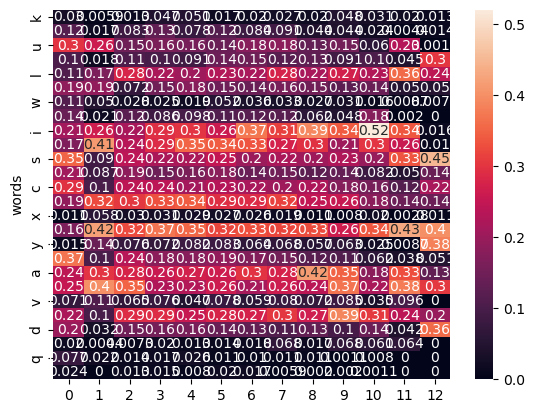

In [159]:
df,predicted_alphabets, col_index = letters_entrophy_df(thirteen_letter_words)
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")


In [ ]:
# Target word = prevaricators
# Predicted word = i but not on index 10
# Lives Left = 6
# ______i______
# 13 letter word

Previous List length is 12956 and Now it is 435
Predicted_Alphabets is e on index = 10


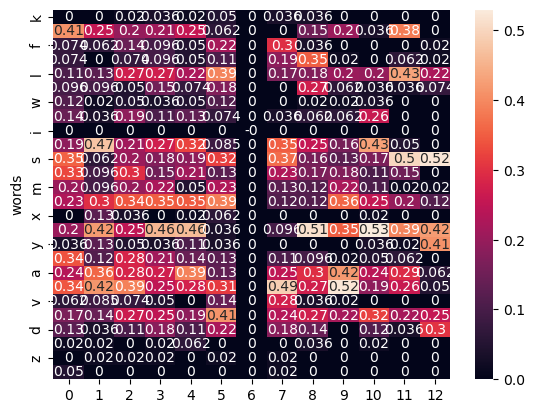

In [181]:
second_list = [words for words in thirteen_letter_words if "i" not in words[:6] and "i" not in words[6+1:] and words[6] == 'i']
df,predicted_alphabets, col_index = letters_entrophy_df(second_list)
print(f"Previous List length is {len(thirteen_letter_words)} and Now it is {len(second_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")


In [ ]:
# Target word = prevaricators
# Predicted word = s and on index 12
# Lives Left = 6
# ______i_____s
# 13 letter word

Previous List length is 973 and Now it is 112
Predicted_Alphabets is f on index = 7


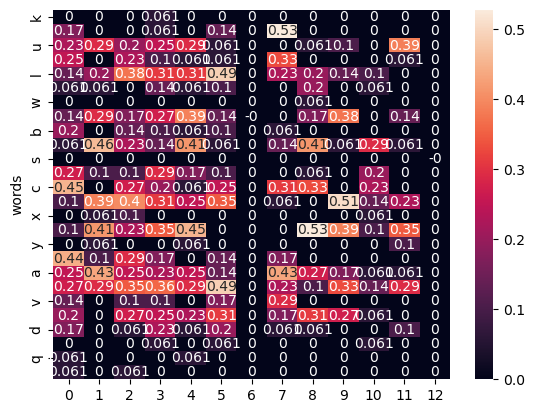

In [170]:
third_list = [words for words in second_list if words[12] == 's' and "s" not in words[:12]]
df,predicted_alphabets, col_index = letters_entrophy_df(third_list)
print(f"Previous List length is {len(second_list)} and Now it is {len(third_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = f NOT in Target word
# Lives Left = 6 -1 = 5
# ______i_____s
# 13 letter word

Previous List length is 112 and Now it is 69
Predicted_Alphabets is n on index = 5


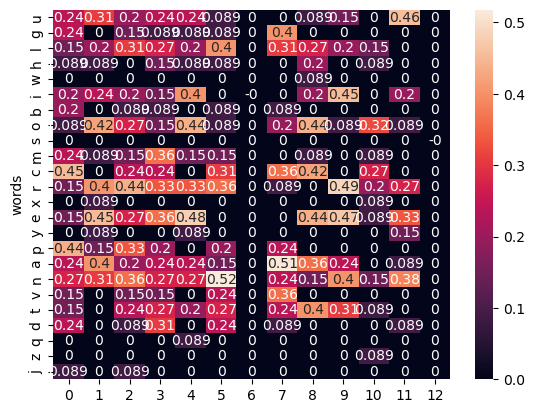

In [171]:
fourth_list = [words for words in third_list if "f" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(fourth_list)
print(f"Previous List length is {len(third_list)} and Now it is {len(fourth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = n NOT in Target word
# Lives Left = 5 - 1 = 4
# ______i_____s
# 13 letter word

Previous List length is 69 and Now it is 16
Predicted_Alphabets is l on index = 5


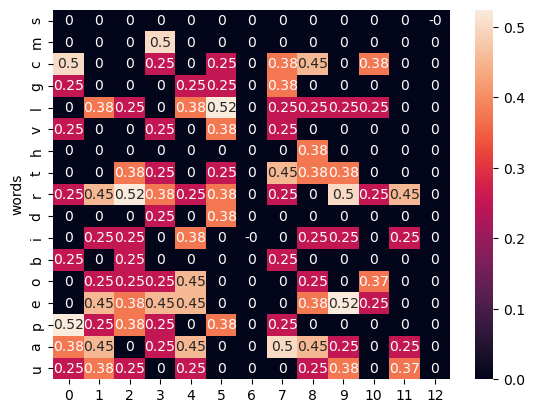

In [172]:
fifth_list = [words for words in fourth_list if "n" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(fifth_list)
print(f"Previous List length is {len(fourth_list)} and Now it is {len(fifth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = l NOT in Target word
# Lives Left = 4 - 1 = 3
# ______i_____s
# 13 letter word

Previous List length is 16 and Now it is 5
Predicted_Alphabets is t on index = 7


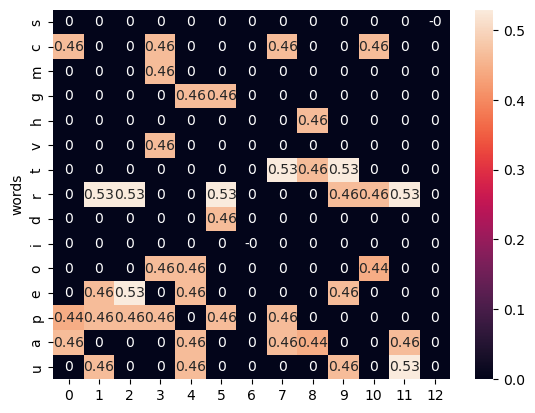

In [173]:
sixth_list = [words for words in fifth_list if "l" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(sixth_list)
print(f"Previous List length is {len(fifth_list)} and Now it is {len(sixth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = t NOT 7th Index
# Lives Left = 3
# ______i__t__s
# 13 letter word

Previous List length is 5 and Now it is 2
Predicted_Alphabets is m on index = 3


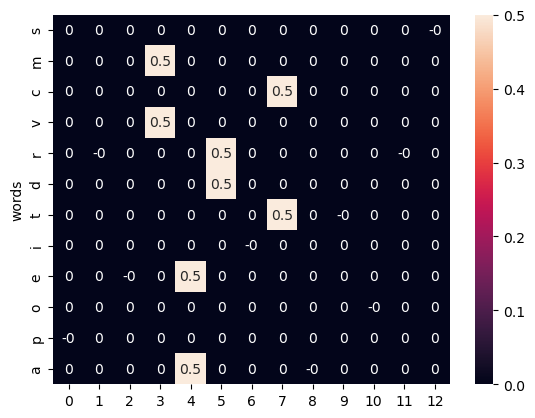

In [176]:
seventh_list = [words for words in sixth_list if words[9] == "t" and words[:9] != "t" and words[9+1:] != "t"]
df,predicted_alphabets, col_index = letters_entrophy_df(seventh_list)
print(f"Previous List length is {len(sixth_list)} and Now it is {len(seventh_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [177]:
# Target word = prevaricators
# Predicted word = m NOT in the target word
# Lives Left = 3 - 1 = 2
# ______i__t__s
# 13 letter word

['premeditators', 'prevaricators']

Previous List length is 2 and Now it is 1
Predicted_Alphabets is s on index = 0


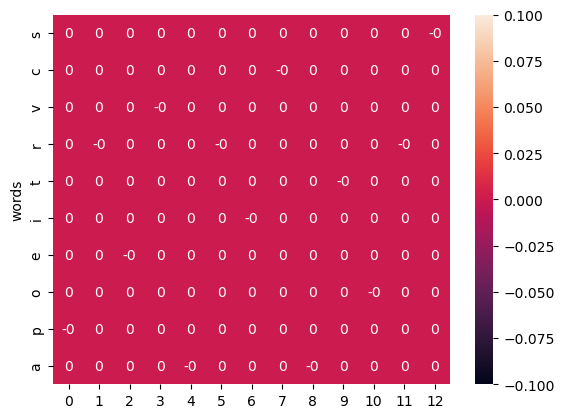

In [178]:
eighth_list = [words for words in seventh_list if "m" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(eighth_list)
print(f"Previous List length is {len(seventh_list)} and Now it is {len(eighth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

# Model 2 - Cosine Similarity

## Bad Model, not built efficiently

In [30]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []
        self.common_letters = ''
        

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)
    
    
    def guess_here(self):
        
        #Guessing the first word using random guess, based on MOST COMMON LETTERS
        random_guess_char = "eariotns"
        """
        Most Common Letters in percentage
        E – 11.1607%
        A – 8.4966%
        R – 7.5809%
        I – 7.5448%
        O – 7.1635%
        T – 6.9509%
        N – 6.6544%
        S – 5.7351%
        
        """
        if len(re.findall(r"[a-zA-Z]+","".join(self.word_in_progress)))== 0:
            for char in range(len(random_guess_char)):
                if random_guess_char[char] in self.common_letters:
                    continue
                else:
                    self.common_letters += random_guess_char[char]
                    left_guesses = self.guesses_left
                    return random_guess_char[char]
        
        #predicted_char = len(re.findall(r"[a-zA-Z]+","".join(self.word_in_progress)))

        #first take the incomplete word from word_in_progress
        incomplete_word = "".join(self.word_in_progress)
        #Find all the same length words from the final_list to predict the next letter
        words_with_same_length = [char for char in self.word_list if len(char) == len(self.word_in_progress)]
        
        # Convert them into vectors using CountVectorizer
        vectorizer = CountVectorizer(analyzer = 'char')
        
        words_with_same_length_vector = vectorizer.fit_transform(words_with_same_length)
        
        incomplete_word_vector = vectorizer.transform([incomplete_word])
        similarities = cosine_similarity(words_with_same_length_vector, incomplete_word_vector)
        
        similar_dic = {}
        for i,j in enumerate(similarities.tolist()):
            similar_dic[i] = j[0]

        sorted_list = sorted(similar_dic.items(),key = lambda x:x[1],reverse = True)

        similar_values = [words_with_same_length[sorted_list[i][0]] for i in range(len(sorted_list))]
        
        def count_sorted_list(word):
            new_dic = {}
            for i in word:
                if i not in new_dic:
                    new_dic[i] = 1
                else:
                    new_dic[i] +=1
            new_list = list(dict((sorted(new_dic.items(),reverse = True,key = lambda x:x[1]))).keys())
            return new_list
        
        previous_guesses_left = self.guesses_left

        while True:
            current_guesses_left = self.guesses_left  # Record current value
            # logic to check guessed letters and return i for each similar_value
            for similar_word in similar_values:
                for i in count_sorted_list(similar_word):
                    if i not in self.guessed_letters:
                        
                        if current_guesses_left != previous_guesses_left:
                            
                            break  # Break the loop if guesses_left changes
                        return i
                if current_guesses_left == previous_guesses_left:
                    previous_guesses_left = current_guesses_left  # Update previous value
                else:
                    break  # Break if guesses_left changes


        
        
        

    def make_guess(self, letter):
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}"

# Example usage:
word_list = all_words
#word_list = ['aion']
custom_hangman = HangmanGame(word_list)
custom_hangman.choose_word()

print("Welcome to Hangman!")
print("Word to guess:", custom_hangman.display_word())

while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
    #guess = input("Enter your guess: ").lower()
    guess = custom_hangman.guess_here()
    result = custom_hangman.make_guess(guess)
    print(result)

print("Game over.")


Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ e _ _
Lives left: 6
d _ _ _ _ _ _ _ e _ _
Lives left: 6
d _ _ _ _ _ _ n e _ _
Lives left: 6
d _ _ _ _ _ _ n e s s
Lives left: 6
d _ _ _ _ _ l n e s s
Lives left: 6
d _ _ _ _ _ l n e s s
Lives left: 5
d _ _ _ _ _ l n e s s
Lives left: 4
d _ _ i _ _ l n e s s
Lives left: 4
d _ _ i _ _ l n e s s
Lives left: 3
d _ _ i _ _ l n e s s
Lives left: 2
d u _ i _ u l n e s s
Lives left: 2
d u t i _ u l n e s s
Lives left: 2
Congratulations! You guessed the word: dutifulness
Game over.
